In [1]:
import os
from typing import List, TypedDict

from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph

# .env 파일에서 환경 변수를 로드합니다.
# 이 파일을 통해 API 키를 안전하게 관리할 수 있습니다.
load_dotenv()

# --- 1. 그래프의 상태(State) 정의 ---
# 그래프의 각 노드(에이전트)는 이 상태 객체를 공유하고 업데이트합니다.
# TypedDict를 사용하여 상태의 구조를 명확하게 정의합니다.
class GraphState(TypedDict):
    story_parts: List[str]  # 지금까지 생성된 이야기 조각들을 리스트로 저장합니다.


# --- 2. 노드(Node)로 사용할 함수 정의 ---
# 각 노드는 그래프의 상태를 입력으로 받고, 상태의 일부를 변경하여 반환합니다.

def call_main_agent(state: GraphState):
    """
    메인 에이전트 노드입니다. Gemini API를 호출하여 다음 이야기 조각을 생성합니다.
    """
    # 현재까지의 상태에서 필요한 정보를 추출합니다.
    story_parts = state["story_parts"]
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.7)
    # Gemini API에 전달할 프롬프트를 구성합니다.
    # 이전 이야기 내용을 함께 전달하여 맥락을 유지하도록 합니다.
    prompt = f"""
    당신은 장면을 묘사하는 뛰어난 소설가입니다. 이 세계는 21세기 한국입니다. 이전 장면을 이어서 다음 장면을 한두 문장으로 묘사해주세요.
    등장인물의 대사나 행동은 추가하지 말고, 오직 주변 상황과 배경 묘사에만 집중해주세요.

    [이전 장면]
    {''.join(story_parts)}

    [다음 장면 묘사]
    """

    # API를 호출하여 다음 이야기 조각을 생성합니다.
    response = llm.invoke(prompt)
    next_part = response.content

    print(f"--- 생성된 장면---")
    print(next_part)

    # 상태를 업데이트하여 반환합니다.
    return {
        "story_parts": story_parts + [next_part], # 생성된 이야기를 리스트에 추가
    }
def call_hamlet_agent(state:GraphState):
    """
    서브 에이전트: 햄릿 캐릭터의 반응을 담당합니다.
    메인 에이전트가 만든 상황에 햄릿이 어떻게 반응할지 생성합니다.
    """    
    story_parts = state["story_parts"]
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.7)
    
    prompt = f"""
    당신은 윌리엄 셰익스피어의 작품 '햄릿'의 '햄릿'입니다. 지금까지의 상황에서 햄릿이 어떻게 행동하고 반응할지 한두 문장으로 작성하세요.
    햄릿의 관점에서 행동, 대사, 생각을 표현해주세요.

    [지금까지의 상황]
    {''.join(story_parts)}

    [햄릿의 반응]
    """

    response = llm.invoke(prompt)
    next_part = response.content

    print(f"\n---  서브 에이전트 (햄릿) ---")
    print(next_part)

    return {
        "story_parts": story_parts + [next_part],
    }

# --- 3. 조건부 엣지(Edge)로 사용할 함수 정의 ---
# 이 함수는 다음으로 이동할 노드를 결정합니다.

def should_continue(state: GraphState):
    """
    사용자 입력에 따라 이야기 생성을 계속할지 결정하는 조건부 엣지입니다.
    """
    user_input = input("계속하시겠습니까? (continue/end): ").strip().lower()
    
    if user_input == "continue":
        return "continue"
    elif user_input == "end":
        return "end"
    else:
        print("'continue' 또는 'end'를 입력해주세요.")
        return should_continue(state)  # 올바른 입력까지 반복
    

# --- 4. 그래프 구성 및 컴파일 ---

# 워크플로우를 상태 그래프로 정의합니다.
workflow = StateGraph(GraphState)

# 노드를 그래프에 추가합니다. "main_agent"라는 이름으로 call_main_agent 함수를 등록합니다.
workflow.add_node("main_agent", call_main_agent)
workflow.add_node("hamlet_agent", call_hamlet_agent)

# 그래프의 시작점을 "main_agent" 노드로 설정합니다.
workflow.set_entry_point("main_agent")

# 메인 에이전트 후 햄릿 에이전트로 이동
workflow.add_edge("main_agent", "hamlet_agent")  

# 햄릿 에이전트 후 조건 확인
workflow.add_conditional_edges(
    "hamlet_agent",
    should_continue,
    {
        "continue": "main_agent",  # 메인에게 넘기기
        "end": END
    }
)

# 그래프를 실행 가능한 객체로 컴파일합니다.
app = workflow.compile()

# --- 5. 그래프 실행 ---

# 그래프를 실행하고 결과를 출력합니다.
# 초기 상태값을 비어 있는 상태로 전달합니다.
a = input()
initial_state = {"story_parts": [a]}
final_state = app.invoke(initial_state)

print("\n--- 최종 결과물 ---")
print("".join(final_state['story_parts']))


--- 생성된 장면---
모니터에서는 여전히 복잡한 코딩 화면이 빛을 뿜어내고 있었지만, 스나의 시선은 멈춰버린 듯 미동도 없었다.

---  서브 에이전트 (햄릿) ---
아, 이 차가운 세상의 유리처럼 느껴지는구나. 저 복잡한 코딩처럼, 내 마음도 풀리지 않는 수수께끼로 가득 차 있도다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?
--- 생성된 장면---
어둠이 짙게 드리운 방 안, 모니터만이 유일한 광원인 듯 푸르스름한 빛을 흩뿌리며 스나의 굳은 얼굴을 희미하게 비췄다.

---  서브 에이전트 (햄릿) ---
아, 이 세상의 차가운 유리처럼 느껴지는구나! 저 복잡한 코딩처럼 내 마음도 풀리지 않는 수수께끼로 가득 차 있으니, 살 것인가 죽을 것인가, 그것이 문제로다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?

--- 최종 결과물 ---
차가운 유리창에 기대고 있던 이마가 떨어졌다. 스나는 소리 없이 몸을 돌려 다시 컴퓨터 책상 앞으로 걸어갔다모니터에서는 여전히 복잡한 코딩 화면이 빛을 뿜어내고 있었지만, 스나의 시선은 멈춰버린 듯 미동도 없었다.아, 이 차가운 세상의 유리처럼 느껴지는구나. 저 복잡한 코딩처럼, 내 마음도 풀리지 않는 수수께끼로 가득 차 있도다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?어둠이 짙게 드리운 방 안, 모니터만이 유일한 광원인 듯 푸르스름한 빛을 흩뿌리며 스나의 굳은 얼굴을 희미하게 비췄다.아, 이 세상의 차가운 유리처럼 느껴지는구나! 저 복잡한 코딩처럼 내 마음도 풀리지 않는 수수께끼로 가득 차 있으니, 살 것인가 죽을 것인가, 그것이 문제로다. 무엇을 해야 할까, 어떻게 해야 이 혼란에서 벗어날 수 있을까?


데이터 통신: 신호(Signals) 핵심 요점 정리

1. 물리 계층(Physical Layer)의 역할과 기능

1.1. 물리 계층의 핵심 임무

OSI 7계층 모델의 가장 첫 번째 계층인 물리 계층(Physical Layer)은 데이터 통신의 가장 기본적인 토대를 마련하는 중요한 역할을 담당합니다. 이 계층은 상위 계층에서 전달된 데이터 비트 스트림(0과 1의 연속)을 실제 전송 매체를 통해 전달될 수 있는 물리적인 신호로 변환하고 전송하는 모든 과정을 책임집니다. 즉, 데이터 통신의 물리적 현실을 구현하는 전략적 심장부라 할 수 있습니다.

물리 계층이 수행하는 주요 임무는 다음과 같이 요약할 수 있습니다.

* 데이터 링크 계층에 대한 서비스 제공: 상위 계층인 데이터 링크 계층이 원활하게 작동할 수 있도록 필요한 물리적 연결 및 전송 서비스를 제공합니다.
* 비트 스트림을 신호로 변환: 0과 1로 구성된 디지털 비트 스트림을 전기적, 광학적 신호 등 전송 매체에 적합한 형태로 변환합니다.
* 물리적 네트워크 및 전송 매체 제어: 케이블, 커넥터 등 물리적 전송 매체의 특성을 제어하고 네트워크의 물리적 구성을 관리합니다.
* 데이터 흐름 방향 구현: 데이터가 한쪽으로만 흐르는 단방향(Simplex), 양쪽으로 흐르되 동시는 아닌 반이중(Half-duplex), 양방향 동시 전송이 가능한 전이중(Full-duplex) 방식을 구현합니다.
* 상이한 데이터 소스를 위한 논리 채널 설정: 하나의 전송 매체를 여러 개의 논리적 채널로 나누어(다중화, Multiplexing) 여러 데이터 소스가 동시에 통신할 수 있도록 합니다.

서비스 상세 분석

물리 계층이 제공하는 구체적인 서비스는 다음과 같습니다.

* Bit-to-signal transformation (비트-신호 변환): 논리적인 비트(0, 1)를 물리적인 신호로 표현합니다.
* Bit-rate control (비트율 제어): 초당 전송되는 비트의 수를 제어하며, 이는 통신 표준에 의해 정의됩니다.
* Bit-synchronization (비트 동기화): 송신자와 수신자 간의 타이밍을 맞추기 위한 클록킹 메커니즘을 제공하여 비트를 정확히 구분할 수 있게 합니다.
* Multiplexing (다중화): 여러 개의 저속 채널을 하나의 고속 채널로 결합하여 전송 효율을 높입니다.

물리 계층의 가장 근본적인 작업은 데이터를 전송 가능한 '신호'로 변환하는 것입니다. 다음 장에서는 데이터 통신의 기본 단위인 신호의 본질에 대해 더 자세히 알아보겠습니다.

2. 신호(Signals)의 기본 개념

2.1. 아날로그 신호와 디지털 신호의 정의 및 비교

데이터를 전송 매체를 통해 보내기 위해서는 반드시 신호(Signal) 형태로 변환해야 합니다. 데이터는 추상적인 정보 단위인 반면, 신호는 그 정보를 물리적으로 표현하고 전달하는 매개체이기 때문입니다. 신호는 크게 아날로그(Analog)와 디지털(Digital)이라는 두 가지 기본 형태로 나뉩니다.

* 아날로그 신호 (Analog Signals): 특정 범위 내에서 연속적인 값을 가지며, 무한한 수의 값으로 표현될 수 있습니다. 마치 사람의 목소리처럼 부드럽게 변하는 파형을 가집니다.
* 디지털 신호 (Digital Signals): 정해진 몇 개의 이산적인 값만 가질 수 있습니다. 예를 들어, 0과 1 두 가지 레벨만으로 표현되는 경우가 대표적입니다.

신호는 시간에 따라 반복되는 패턴을 갖는 **주기적 신호(Periodic)**와 그렇지 않은 **비주기적 신호(Aperiodic)**로도 구분됩니다. 데이터 통신에서는 일반적으로 주기적인 아날로그 신호와 비트 패턴에 기반한 비주기적인 디지털 신호가 주로 사용됩니다.

이제 아날로그 신호의 구체적인 특성을 먼저 심도 있게 분석해 보겠습니다.

3. 아날로그 신호(Analog Signals)의 특성 분석

3.1. 사인파(Sine Wave)의 구성 요소

아날로그 신호를 이해하는 데 있어 가장 기본이 되는 형태는 사인파(Sine Wave)입니다. 사인파가 중요한 이유는 '푸리에 분석'에 따라 모든 복합 아날로그 신호는 서로 다른 주파수, 진폭, 위상을 가진 단순한 사인파들의 조합으로 표현될 수 있기 때문입니다.

단순 사인파는 다음의 3가지 핵심 속성으로 구성됩니다.

* 최대 진폭 (Peak Amplitude): 파형의 최고점 또는 최저점의 크기로, 신호의 세기를 나타냅니다.
* 주파수 (Frequency): 1초 동안 파형이 반복되는 횟수로, 헤르츠(Hz) 단위로 측정됩니다.
* 위상 (Phase): 시간 0을 기준으로 한 파형의 시작 위치를 나타내며, 신호의 시간적 이동을 표현합니다.

이러한 속성은 다음 수식으로 표현될 수 있습니다.

s(t) = A sin(2πft + φ)

* A: 최대 진폭 (Peak Amplitude)
* f: 주파수 (Frequency)
* φ: 위상 (Phase)

3.2. 주파수(Frequency)와 주기(Period)

주파수(Frequency)와 주기(Period)는 서로 밀접한 관계를 가집니다. 주기는 파형이 한 번 반복되는 데 걸리는 시간이며, 주파수는 1초 동안의 반복 횟수이므로 두 값은 서로 역수 관계입니다.

단위 (Unit)	환산 값 (Equivalent)
Seconds (s)	1 s
Milliseconds (ms)	10⁻³ s
Microseconds (μs)	10⁻⁶ s
Nanoseconds (ns)	10⁻⁹ s
Picoseconds (ps)	10⁻¹² s
Hertz (Hz)	1 Hz
Kilohertz (KHz)	10³ Hz
Megahertz (MHz)	10⁶ Hz
Gigahertz (GHz)	10⁹ Hz
Terahertz (THz)	10¹² Hz

주파수는 본질적으로 '시간에 대한 변화율'을 의미합니다.

* 짧은 시간 동안 신호가 급격히 변하면 높은 주파수를 의미합니다.
* 긴 시간에 걸쳐 신호가 완만하게 변하면 낮은 주파수를 의미합니다.
* 신호가 전혀 변하지 않는다면(직선) 주파수는 0이며, 순간적으로 변한다면(펄스와 같이) 주파수는 무한대입니다.

3.3. 복합 신호(Composite Signals)와 대역폭(Bandwidth)

단일 주파수를 가진 순수한 사인파만으로는 복잡한 데이터를 전송할 수 없습니다. 유용한 정보를 담기 위해서는 신호의 진폭, 주파수, 위상 등을 변경하고 여러 사인파를 결합하여 **복합 신호(Composite Signal)**를 만들어야 합니다.

**푸리에 분석(Fourier analysis)**은 이러한 복합 신호를 이해하는 핵심 원리입니다. "모든 복합 신호는 다른 주파수, 위상, 진폭을 가진 단순한 사인파의 조합으로 표현될 수 있다"는 것이 그 골자입니다.

대표적인 복합 신호인 사각파(Square Wave)를 예로 들면 다음과 같은 구성 요소를 가집니다.

* 기본 주파수 (Fundamental frequency): 복합 신호를 구성하는 사인파 중 가장 낮은 주파수.
* 고조파 (Harmonics): 기본 주파수의 정수배에 해당하는 주파수. 사각파의 경우, 짝수 고조파는 상쇄되고 홀수 고조파(3f, 5f, 7f...)만 남습니다.

전송 매체가 신호를 얼마나 잘 전달할 수 있는지는 **대역폭(Bandwidth)**에 의해 결정됩니다. 대역폭은 "매체가 통과시킬 수 있는 주파수의 범위"로 정의되며, 이는 매체 고유의 속성입니다. 일반적으로 대역폭은 매체가 통과시킬 수 있는 최고 주파수와 최저 주파수의 차이로 표현됩니다.

만약 전송하려는 신호가 가진 주파수 범위가 매체의 대역폭과 일치하지 않으면 **신호 왜곡(Distortion)**이 발생합니다. 이는 신호의 주파수 성분 중 일부가 매체의 대역폭을 벗어날 경우, 해당 성분들이 손실되거나 심각하게 약화되어 수신된 신호의 형태가 원래 신호와 달라지는 왜곡이 발생함을 의미합니다.

아날로그 신호의 특성을 이해한 것을 바탕으로, 이제 디지털 신호의 특성과는 어떻게 다른지 비교 분석해 보겠습니다.

4. 디지털 신호(Digital Signals)의 특성 분석

4.1. 비트율(Bit Rate)과 대역폭의 관계

디지털 통신을 이해하기 위해서는 디지털 신호의 특성을 분석하는 것이 필수적입니다. 아날로그 신호의 핵심 개념이 '주파수'였다면, 디지털 신호에서는 '비트율'이 그에 상응하는 중요한 개념입니다.

디지털 신호의 시간 및 속도와 관련된 핵심 용어는 다음과 같습니다.

* 비트 간격 (Bit interval): 단일 비트 하나를 보내는 데 걸리는 시간입니다. 이는 아날로그 신호의 '주기(Period)'와 유사한 개념입니다.
* 비트율 (Bit rate): 1초 동안 전송되는 비트의 수(bps, bits per second)입니다. 이는 아날로그 신호의 '주파수(Frequency)'와 유사한 개념입니다.

계산 예시

문제: 디지털 신호의 비트율이 2000 bps일 때, 각 비트의 지속 시간(비트 간격)은 얼마인가?

풀이: 비트 간격은 비트율의 역수입니다.

* 비트 간격 = 1 / 2000 s = 0.0005 s
* 0.0005 s * 10⁶ μs/s = 500 μs

디지털 신호는 이론적으로 무한한 대역폭을 가진 복합 아날로그 신호로 볼 수 있습니다. 푸리에 분석에 따르면 사각파와 같은 디지털 신호는 무한개의 사인파(고조파)가 합쳐진 형태이기 때문입니다. 그렇다면 디지털 신호를 전송하는 데 필요한 최소 대역폭은 어떻게 결정될까요? 이는 신호가 얼마나 빠르게 변하는가에 따라 결정됩니다.

예를 들어 6bps의 비트율을 생각해 봅시다. 가장 변화가 적은 '최선'의 경우('111111')는 신호가 변하지 않으므로 0Hz의 주파수가 필요합니다. 반면, 가장 변화가 잦은 '최악'의 경우('101010')는 2비트마다 하나의 완전한 사이클을 형성합니다. 즉, 1초에 6비트를 보내면 3개의 사이클이 만들어지므로, 3Hz의 기본 주파수가 필요합니다. 이처럼 최악의 경우를 기준으로, 최소 필요 대역폭(B)은 비트율(n)의 절반이 됩니다. 따라서 B = n/2라는 관계가 성립합니다. 더 높은 데이터 전송률(더 선명한 디지털 신호)을 위해서는 더 많은 고조파 성분을 포함해야 하며, 이는 곧 더 넓은 대역폭을 필요로 함을 의미합니다. 일반적으로 B >= n/2의 관계가 성립합니다.

다음 표는 비트율과 필요한 고조파 수에 따라 요구되는 대역폭이 어떻게 증가하는지를 보여줍니다.

Bit Rate	Harmonic 1	Harmonics 1, 3	Harmonics 1, 3, 5	Harmonics 1, 3, 5, 7
1 Kbps	500 Hz	2 KHz	4.5 KHz	8 KHz
10 Kbps	5 KHz	20 KHz	45 KHz	80 KHz
100 Kbps	50 KHz	200 KHz	450 KHz	800 KHz

결론적으로, 디지털 통신에서는 다음과 같은 핵심 관계가 성립합니다. "비트율과 대역폭은 서로 비례한다."

신호의 이론적 특성을 학습했으니, 이제 실제 통신 환경에서 데이터 전송률을 제한하는 요인들에 대해 알아보겠습니다.

5. 데이터 전송률의 한계(Data Rate Limits)

5.1. 이론적 최대 전송률 공식

데이터 전송률은 무한정 높아질 수 없으며, 주어진 채널의 물리적 특성에 따라 명확한 이론적 한계가 존재합니다. 이 한계를 설명하는 가장 중요한 두 가지 이론이 나이퀴스트(Nyquist) 공식과 섀넌(Shannon) 공식입니다.

데이터 전송률에 영향을 미치는 세 가지 주요 요인은 다음과 같습니다.

* 사용 가능한 대역폭
* 사용 가능한 신호 레벨의 수
* 채널의 품질 (잡음 수준)

나이퀴스트 비트율 (무잡음 채널)

잡음이 없는 이상적인 채널에서의 최대 비트율을 정의하며, **나이퀴스트 공식(Nyquist Bit Rate)**은 다음과 같습니다.

BitRate = 2 × bandwidth × log₂(L)

* bandwidth: 채널의 대역폭 (Hz)
* L: 신호 레벨의 수

예시 1: 대역폭이 3000 Hz인 무잡음 채널에서 2개의 신호 레벨(0, 1)을 사용할 때 최대 비트율은? BitRate = 2 × 3000 × log₂(2) = 6000 × 1 = 6000 bps

예시 2: 동일한 채널에서 4개의 신호 레벨(00, 01, 10, 11)을 사용할 때 최대 비트율은? BitRate = 2 × 3000 × log₂(4) = 6000 × 2 = 12,000 bps

섀넌 용량 (잡음 채널)

실제 통신 환경처럼 잡음이 있는 채널에서의 이론적 최대 데이터 전송률을 정의하며, 섀넌 용량(Shannon Capacity) 공식은 다음과 같습니다.

Capacity = bandwidth × log₂(1 + SNR)

* bandwidth: 채널의 대역폭 (Hz)
* SNR (Signal-to-Noise Ratio): 신호 전력 대 잡음 전력의 비율로, 채널의 품질을 나타냅니다.

예시: 일반 전화선은 대역폭이 3000 Hz이고 SNR이 약 3162일 때, 이론적인 최대 비트율은? Capacity = 3000 × log₂(1 + 3162) = 3000 × log₂(3163) Capacity ≈ 3000 × 11.62 = 34,860 bps

나이퀴스트 공식이 신호 레벨(L)에 따른 이상적인 전송률을 제시한다면, 섀넌 용량은 잡음(SNR)이라는 현실적인 제약을 통해 채널이 수용할 수 있는 절대적인 한계를 규정합니다. 즉, 나이퀴스트 공식을 이용해 신호 레벨을 무한정 늘려 비트율을 높이려는 시도는 잡음이 있는 채널에서는 결국 실패합니다. 신호 레벨이 많아질수록 각 레벨 간의 간격은 좁아지는데, 잡음이 심한(SNR이 낮은) 환경에서는 수신 측이 이 미세한 차이를 구분할 수 없기 때문입니다. 따라서, 높은 비트율을 달성하려면 섀넌 공식이 말해주듯 충분히 높은 SNR이 반드시 뒷받침되어야 합니다.

이론적인 한계와 더불어 실제 전송 과정에서 신호 품질을 저하시키는 구체적인 '전송 손상' 요인들에 대해 다음 섹션에서 자세히 다루겠습니다.

6. 전송 손상(Transmission Impairment)

6.1. 신호 품질 저하의 주요 원인

신호가 전송 매체를 통해 이동할 때, 원래의 형태를 완벽하게 유지하기는 어렵습니다. 여러 가지 손상 요인에 의해 신호의 품질이 저하되며, 이는 통신 오류의 주된 원인이 됩니다.

전송 손상의 세 가지 주요 유형은 다음과 같습니다.

* 감쇠 (Attenuation): 매체를 통과하면서 신호의 에너지가 손실되어 신호의 세기가 약해지는 현상입니다.
* 왜곡 (Distortion): 복합 신호를 구성하는 여러 주파수 성분들이 서로 다른 속도로 전파되어 도착 시점에 신호의 형태가 변하는 현상입니다.
* 잡음 (Noise): 원치 않는 외부 신호가 원래의 신호에 유입되어 신호를 교란하는 현상입니다.

감쇠와 데시벨(dB) 분석

감쇠는 매체의 저항으로 인해 신호 에너지가 열에너지 등으로 변환되면서 발생합니다. 이 손실을 보상하기 위해 통신 시스템은 중간에 증폭기(amplifier)를 사용하여 신호를 증폭시킵니다.

신호 세기의 변화를 측정할 때 데시벨(dB) 단위를 사용하는 데에는 두 가지 주요한 이유가 있습니다. 첫째, 전력의 매우 넓은 범위(예: 10³ 와 10⁻⁶)를 관리하기 쉬운 숫자(90dB)로 압축할 수 있습니다. 둘째, 여러 구간으로 구성된 시스템의 전체 이득과 손실을 각 구간의 dB 값을 단순히 더하거나 빼는 방식으로 간단하게 계산할 수 있습니다.

dB = 10 log₁₀(P₂/P₁) (여기서 P₁은 기준 전력, P₂는 측정된 전력)

예시 1 (감쇠): 신호의 전력이 절반으로 감소(P₂ = 0.5P₁)했다면? 10 log₁₀(0.5P₁/P₁) = 10 log₁₀(0.5) ≈ 10 × (-0.3) = -3 dB (3dB 손실을 의미)

예시 2 (증폭): 신호의 전력이 10배로 증가(P₂ = 10P₁)했다면? 10 log₁₀(10P₁/P₁) = 10 log₁₀(10) = 10 × 1 = 10 dB (10dB 이득을 의미)

왜곡과 잡음 분석

* 왜곡(Distortion): 주로 복합 신호에서 발생하며, 각 주파수 성분이 매체를 통해 전파되는 속도가 미세하게 달라 수신단에 도착했을 때 위상이 틀어지면서 원래의 파형이 찌그러지는 현상입니다.
* 잡음(Noise): 잡음에는 여러 종류가 있습니다.
  * 열 잡음 (Thermal noise): 전자의 무작위적인 움직임으로 인해 발생하는 기본적인 잡음.
  * 유도 잡음 (Induced noise): 모터나 가전제품 등 주변 기기로부터 발생하는 전자기 간섭(EMI).
  * 혼선 (Crosstalk): 인접한 케이블의 신호가 서로에게 영향을 미치는 현상.
  * 충격 잡음 (Impulse noise): 번개나 전원 스위치 작동 시 발생하는 순간적인 고에너지 스파이크.

마지막으로, 신호의 특성을 이해하는 데 도움이 되는 몇 가지 추가적인 개념들을 살펴보며 요점 정리를 마무리하겠습니다.

7. 기타 중요 신호 특성

7.1. 전파 속도, 전파 시간, 파장

데이터 전송 성능을 정확히 이해하기 위해서는 신호의 이론적 특성뿐만 아니라, 신호가 물리적으로 매체를 이동하는 것과 관련된 특성들도 중요합니다.

* 전파 속도 (Propagation Speed): 신호가 1초 동안 매체를 통해 이동할 수 있는 거리입니다. 이 속도는 진공 상태의 빛의 속도(약 3 x 10⁸ m/s)가 최대이며, 사용하는 매체와 신호의 주파수에 따라 달라집니다.
* 전파 시간 (Propagation Time): 신호가 송신 지점에서 수신 지점까지 이동하는 데 걸리는 시간입니다. (전파 시간 = 거리 / 전파 속도)
* 파장 (Wavelength): 신호가 한 주기 동안 전파되는 거리로, 신호의 주기(또는 주파수)와 매체의 전파 속도를 연결하는 중요한 개념입니다.

파장 공식 및 관계 설명

파장(λ)은 다음 두 가지 공식으로 계산할 수 있습니다.

1. λ = vT (파장 = 전파 속도 × 주기)
2. λ = v/f (파장 = 전파 속도 / 주파수)

이 공식은 중요한 관계를 보여줍니다. 파장과 주파수는 서로 반비례하므로(λ = v/f), 파장이 길면(Long wavelength) 이는 곧 **주파수가 낮음(low frequency)**을 의미합니다. 섀넌 용량 공식(Capacity = bandwidth × log₂(1 + SNR))에 따르면, 채널의 최대 데이터 전송률은 사용 가능한 대역폭에 직접적으로 비례합니다. 낮은 주파수 신호 자체가 낮은 대역폭을 의미하는 것은 아니지만, 일반적으로 낮은 주파수 대역에서 동작하도록 설계된 채널은 가용 대역폭이 좁은 경우가 많습니다. 결과적으로, 이는 달성 가능한 최대 데이터 전송률을 낮추는(low data rate) 요인이 될 수 있습니다.


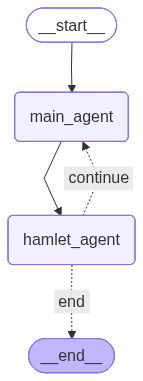

In [2]:
from IPython.display import Image,display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass